# Undersampling & individual Gridsearch

This notebook discusses Multi-label classification methods using undersampling for the [academia.stackexchange.com](https://academia.stackexchange.com/).

A classifier is trained for each label individually. The best parameter is obtained for each classifier using *Gridsearch*. The training data for each classifier is adjusted using *undersampling*. This approach is a combination of the approaches shown in [notebook 4.5.1](4.5.1-me-classwise-gridsearch.ipynb) and [notebook 4.5.2](4.5.2-me-classwise-undersampling.ipynb).

## Table of Contents
* [Data import](#data_import)
* [Data preparation](#data_preparation)
* [Methods](#methods)
* [Evaluation](#evaluation)

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from joblib import dump, load
from pathlib import Path
from academia_tag_recommender.definitions import MODELS_PATH
from academia_tag_recommender.classifier import Classifier, available_classifier_paths

RANDOM_STATE = 0

<a id='data_import'/>

## Data import

In [2]:
from academia_tag_recommender.data import documents
from academia_tag_recommender.test_train_data import get_X_reduced, get_y, get_test_train_data
from academia_tag_recommender.preprocessing_definition import PreprocessingDefinition

def get_X():
    return np.vstack([document.text for document in documents])
y = get_y()

X_train, X_test, y_train, y_test = get_test_train_data(get_X(), y, scale=False)
print('Train set with shape ', X_train.shape)
print('Test set with shape', X_test.shape)

preprocessing = PreprocessingDefinition('tfidf', 'basic', 'basic', 'english', '1,1', 'TruncatedSVD')
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = get_test_train_data(get_X_reduced(preprocessing), y)

preprocessing = PreprocessingDefinition('count', 'basic', 'basic', 'english', '1,1', 'TruncatedSVD')
X_train_count, X_test_count, y_train_count, y_test_count = get_test_train_data(get_X_reduced(preprocessing), y)

Train set with shape  (24812, 1)
Test set with shape (8270, 1)


<a id='data_preparation'/>

## Data Preparation

In [3]:
from academia_tag_recommender.embedded_data import word2vec, doc2vec, fasttext2vec

In [4]:
def get_data(embedding):
    if embedding == 'word2vec':
        X_train_, X_test_ = word2vec(X_train, X_test)
        return X_train_, X_test_, y_train, y_test
    elif embedding == 'doc2vec':
        X_train_, X_test_ = doc2vec(X_train, X_test)
        return X_train_, X_test_, y_train, y_test
    elif embedding == 'fasttext':
        X_train_, X_test_ = fasttext2vec(X_train, X_test)
        return X_train_, X_test_, y_train, y_test
    elif embedding == 'tfidf':
        return X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf
    elif embedding == 'count':
        return X_train_count, X_test_count, y_train_count, y_test_count

In [5]:
paths = available_classifier_paths('classwise')
def create_classifier(classifier_options, name, embedding):
    path = [path for path in paths if name in path.name and embedding in path.name]
    if len(path) > 0:
        clf = load(path[0])
    else:
        preprocessing = PreprocessingDefinition(embedding, 'basic', 'basic', 'english', '1,1', 'None')
        classifier = ClasswiseClassifier(classifier_options, embedding, undersample=True)
        clf = Classifier(classifier, preprocessing, name)
        X_train_, X_test_, y_train_, y_test_ = get_data(embedding)
        clf.fit(X_train_, y_train_)
        clf.score(X_test_, y_test_)
        clf.save('classwise')
    print('Training: {}s'.format(clf.training_time))
    print('Test: {}s'.format(clf.test_time))
    clf.evaluation.print_stats()

<a id='training'/>

## Training

The [Classwise Classifier](../classwise_classifier.py) is trained for three different classification methods and their specific tuning parameter is found using [Gridsearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV) as in [notebook 4.5.1](4.5.1-me-classwise-gridsearch.ipynb).
- Linear SVC, optimizing parameter `C`
- Logistic Regression, optimizing parameter `C`
- MLPClassifier, optimizing parameter `alpha`

[Recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html?highlight=recall#sklearn.metrics.recall_score) is used as  the scoring-function for the optimization. For reasons of that decision see [notebook 3.0](3.0-me-evaluation-metrics.ipynb).

In addition undersampling is used for each individual label as in [notebook 4.5.2](4.5.2-me-classwise-undersampling.ipynb) Instead of handing all samples to the classifier, a more balanced ratio is used as training data. The [Classwise Classifier](../classwise_classifier.py) uses a ratio of 1:25, depending on how many positive samples are available in the original data.

In [6]:
from academia_tag_recommender.classwise_classifier import ClasswiseClassifier, ClassifierOption
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

**Word2Vec**

In [7]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-gridsearch-undersample', 'word2vec')

Training: 524.9049725532532s
Test: 1.9986634254455566s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.015918029656971935     0.03784764207980653      0.3513578565059823       0.30342200725513907      0.29129328819776223      
micro                                                            0.37489241362350917      0.29118517811097316      0.32777897226402924      
macro                                                            0.2876996690137547       0.33687175776680117      0.24773258402994713      


In [8]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-gridsearch-undersample', 'word2vec')

Training: 226.88243222236633s
Test: 2.3747541904449463s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.014169159294851397     0.04969770253929867      0.38903557513291487      0.30997178557033456      0.31155161176322         
micro                                                            0.4524528844770537       0.3003533568904594       0.3610377683388819       
macro                                                            0.3133059172958119       0.29665226329757977      0.27351215336005735      


In [9]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-gridsearch-undersample', 'word2vec')

Training: 14650.26878118515s
Test: 10.427809238433838s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.017321962706039584     0.031076178960096734     0.3850082793734547       0.40571140669085043      0.3569426200562839       
micro                                                            0.3631404381600768       0.3972596199751743       0.3794345645234838       
macro                                                            0.2513141798261965       0.38654081773759896      0.27927845875150525      


**Doc2Vec**

In [10]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-gridsearch-undersample', 'doc2vec')

Training: 3187.318448781967s
Test: 3.0484893321990967s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.027731814421179914     0.013663845223700122     0.13544451307905767      0.2086074163643692       0.13729246784704258      
micro                                                            0.1403319132701723       0.21070218148837652      0.16846363757800123      
macro                                                            0.18264480696335833      0.2927405660720839       0.14860532416159333      


In [11]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-gridsearch-undersample', 'doc2vec')

Training: 162.00708532333374s
Test: 3.134815216064453s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.0286450709603513       0.013905683192261185     0.1590107501934149       0.255975413139863        0.16284833750486793      
micro                                                            0.15565160145404586      0.2595827963148599       0.19461045700175356      
macro                                                            0.17095042623451026      0.3328139883095089       0.1652792358082531       


In [12]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-gridsearch-undersample', 'doc2vec')

Training: 986.8321974277496s
Test: 8.625989198684692s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.02421689047285687      0.016444981862152357     0.2605807317352741       0.3413401854091092       0.25959817238467914      
micro                                                            0.2261142418032787       0.33718487394957986      0.27069917203311866      
macro                                                            0.17873417571177613      0.3673094462037731       0.21259417900135336      


**FastText**

In [13]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-gridsearch-undersample', 'fasttext')

Training: 554.8350341320038s
Test: 2.2174670696258545s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.015898300770063004     0.03857315598548972      0.3603681354920775       0.3214873035066505       0.3039716819523349       
micro                                                            0.3811569469781675       0.3092827810142298       0.34147884539343615      
macro                                                            0.3096040767729143       0.378431980782939        0.27736000973430935      


In [14]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-gridsearch-undersample', 'fasttext')

Training: 270.73062014579773s
Test: 2.207023859024048s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013551836059313944     0.057678355501813786     0.4117453119901729       0.3199476017734784       0.3248283565151764       
micro                                                            0.4867310012062726       0.3082800114602235       0.37747763550254343      
macro                                                            0.3554276812692804       0.30579795800381004      0.3000381628093952       


In [15]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-gridsearch-undersample', 'fasttext')

Training: 7961.142310142517s
Test: 10.338266372680664s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01730859797619805      0.031922611850060456     0.39575015459144747      0.4139701733172108       0.36322224396589575      
micro                                                            0.36516975108925415      0.4041344409433782       0.3836653296167879       
macro                                                            0.26387902468947305      0.41651453343730616      0.29511705677446387      


**TFIDF**

In [16]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-gridsearch-undersample', 'tfidf')

Training: 12949.546083927155s
Test: 16.880247116088867s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.016375612550117737     0.03530834340991536      0.38470648356077614      0.3841334139459895       0.3516354416777633       
micro                                                            0.38369281361833835      0.37923617417905453      0.38145147719897116      
macro                                                            0.4171859248672874       0.3595296429793058       0.3793471743293597       


In [17]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-gridsearch-undersample', 'tfidf')

Training: 4069.2164857387543s
Test: 16.53016757965088s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013852224272895055     0.057799274486094315     0.4192819715552485       0.33011084240225713      0.3397151773391193       
micro                                                            0.4707024478191526       0.3244586778834664       0.38413219399015336      
macro                                                            0.5191454340034776       0.26477751835146074      0.3366718221084403       


In [18]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-gridsearch-undersample', 'tfidf')

Training: 37594.0929877758s
Test: 57.679810523986816s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.03399159931267104      0.005078597339782346     0.20856456996188324      0.37876058041112454      0.24125598060439213      
micro                                                            0.16284189321094059      0.3744150510934963       0.22696944697726254      
macro                                                            0.18079568117432637      0.44238114176548343      0.20144233641057877      


**Count**

In [19]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-gridsearch-undersample', 'count')

Training: 15218.472132921219s
Test: 17.3472797870636s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.027713994781391204     0.023337363966142683     0.253848156360735        0.3467130189439742       0.25708580190298863      
micro                                                            0.1969371882207799       0.3505513916073901       0.2521937732900589       
macro                                                            0.23424971590685387      0.2916911587582089       0.24723694887696754      


In [20]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-gridsearch-undersample', 'count')

Training: 4438.102316379547s
Test: 16.668318510055542s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01912874689747343      0.03385731559854897      0.3017917796968583       0.2812676340185409       0.25977003416817207      
micro                                                            0.28282635644130827      0.28319091039289634      0.28300851601822474      
macro                                                            0.34773705089073415      0.19627252952792418      0.23478481128356096      


In [21]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-gridsearch-undersample', 'count')

Training: 8418.393253087997s
Test: 60.2276885509491s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.04137847642079807      0.016324062877871828     0.215325294101805        0.34390366787585647      0.2241051563959696       
micro                                                            0.12316374519025225      0.34382011743925145      0.18136032837249128      
macro                                                            0.11630243821474937      0.3905585644828027       0.1505967198359981       


<a id='evaluation'/>

## Evaluation

In [22]:
paths = available_classifier_paths('classwise')
paths = [path for path in paths if 'gridsearch-undersample' in path.name]

In [23]:
evals = []
for path in paths:
    clf = load(path)
    evaluation = clf.evaluation
    evals.append([str(clf) + ' ' + str(clf.preprocessing.vectorizer), evaluation])

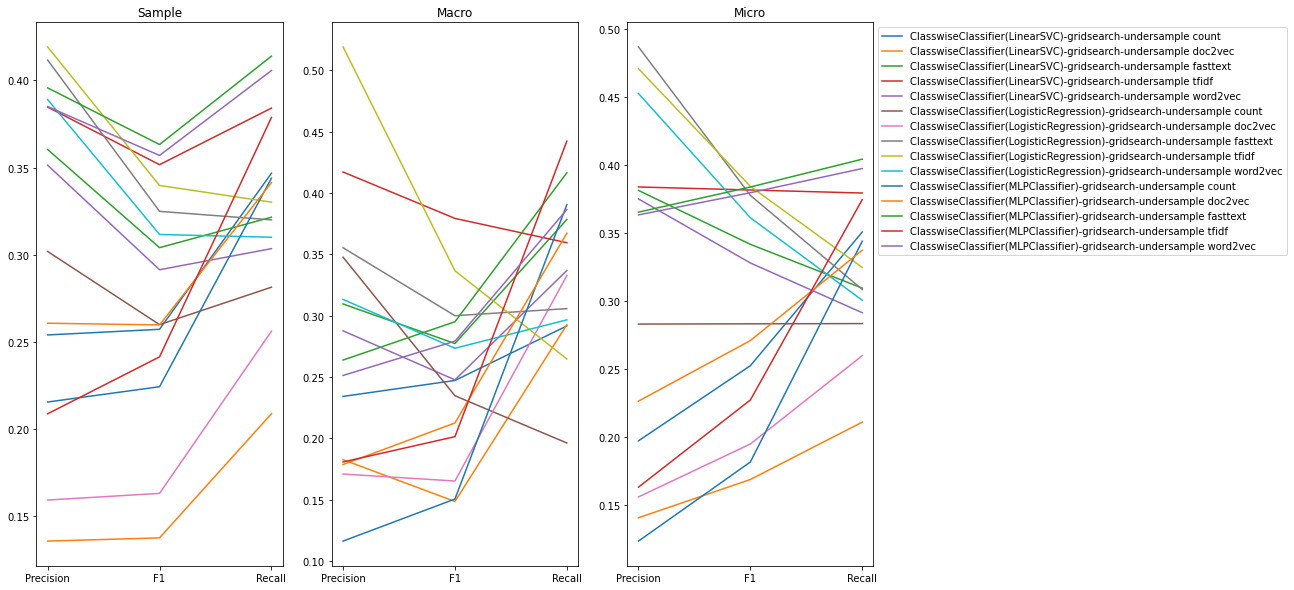

In [24]:
x_ = ['Precision', 'F1', 'Recall']
fig, axes = plt.subplots(1, 3, figsize=(15,10))
axes[0].set_title('Sample')
axes[1].set_title('Macro')
axes[2].set_title('Micro')
for eval_ in evals:
    evaluator = eval_[1]
    axes[0].plot(x_, [evaluator.precision_samples, evaluator.f1_samples, evaluator.recall_samples], label=eval_[0])
    axes[1].plot(x_, [evaluator.precision_macro, evaluator.f1_macro, evaluator.recall_macro], label=eval_[0])
    axes[2].plot(x_, [evaluator.precision_micro, evaluator.f1_micro, evaluator.recall_micro], label=eval_[0])
axes[2].legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()

In [25]:
top_3 = sorted(paths, key=lambda x: load(x).evaluation.recall_macro, reverse=True)[:3]

In [26]:
def per_label_accuracy(orig, prediction):
    if not isinstance(prediction, np.ndarray):
        prediction = prediction.toarray()
    l = 1 - orig - prediction
    return np.average(l, axis=0)

In [27]:
from sklearn.metrics import classification_report
classwise_results = []
for clf_path in top_3:
    clf = load(clf_path)
    _, X_test_, _, y_test_ = get_data(clf.preprocessing.vectorizer)
    prediction = clf.predict(X_test_)
    label_accuracies = per_label_accuracy(y_test_, prediction)
    report = classification_report(y_test_, prediction, output_dict=True, zero_division=0)
    classwise_report = {}
    for i, result in enumerate(report):
        if i < len(label_accuracies):
            classwise_report[result] = report[result]
            classwise_report[result]['accuracy'] = label_accuracies[int(result)]
    classwise_results.append((str(clf) + ' ' + str(clf.preprocessing.vectorizer), classwise_report))

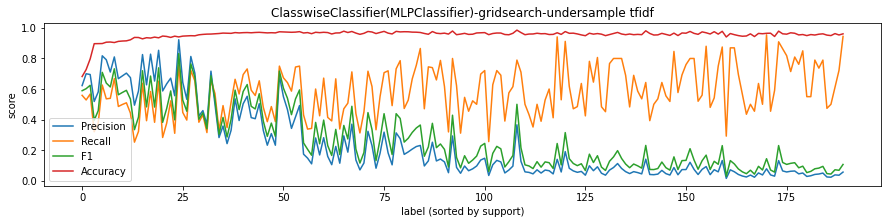

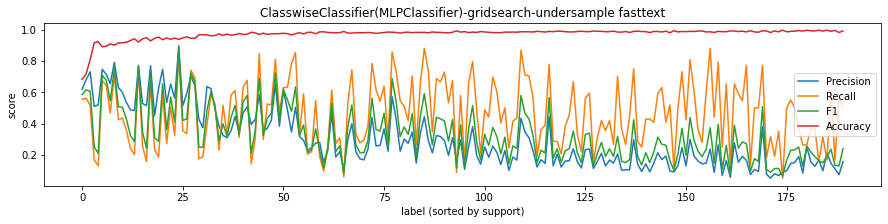

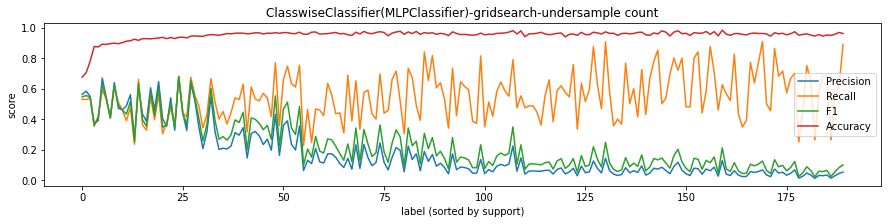

In [28]:
import numpy as np
x_ = np.arange(0, len(y_test[0]))
for classwise_result in classwise_results:
    name, results = classwise_result
    _, fig_1 = plt.subplots(figsize=(15,3))
    fig_1.set_title(name)
    sorted_results = sorted(results, key=lambda x: results[x]['support'], reverse=True)
    fig_1.plot(x_, [results[result]['precision'] for result in sorted_results][0:len(x_)], label='Precision')
    fig_1.plot(x_, [results[result]['recall'] for result in sorted_results][0:len(x_)], label='Recall')
    fig_1.plot(x_, [results[result]['f1-score'] for result in sorted_results][0:len(x_)], label='F1')
    fig_1.plot(x_, [results[result]['accuracy'] for result in sorted_results][0:len(x_)], label="Accuracy")
    fig_1.set_xlabel('label (sorted by support)')
    fig_1.set_ylabel('score')
    fig_1.legend(loc='best')
plt.show()